In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas
import torch, torch.utils.data, torchvision
import PIL
import cv2
import os
import os.path
import time
import skimage, skimage.io
import time
import copy

/home/Spartacus/anaconda3/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.24.1) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


# Data Exploration

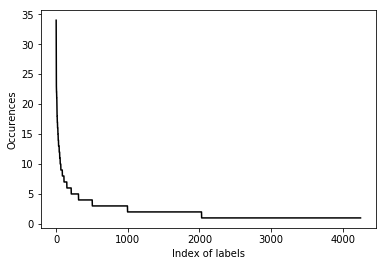

In [2]:
# Load the data and visualize it
df = pandas.read_csv('./data/train.csv')

unique = pandas.value_counts(df.Id)
num_classes = unique.values.shape[0]

plt.figure()
plt.plot(range(1,num_classes),unique.values[1:],'-k')
plt.xlabel('Index of labels')
plt.ylabel('Occurences')
plt.show()

In [3]:
print ("Classes:", num_classes)
print ("Images:",df.shape[0])

Classes: 4251
Images: 9850


In [4]:
grouped = df.groupby('Id')
df['occurrences'] =  grouped.Id.transform('count')
df = df.sort_values('occurrences',ascending=False)
df[:10]

,Image,Id,occurrences
1172,1e484732.jpg,new_whale,810
1230,200b53a2.jpg,new_whale,810
8688,e1eba938.jpg,new_whale,810
5080,842686a1.jpg,new_whale,810
5086,8441a59e.jpg,new_whale,810
5089,847238a3.jpg,new_whale,810
5105,84df4d6d.jpg,new_whale,810
5112,84eec364.jpg,new_whale,810
5119,8504db72.jpg,new_whale,810
5123,851a3114.jpg,new_whale,810


The class 'new_whale' has the highest number of occurrences - 810. To summarize, we can now conclude that the data distribution is highly skewed. Many of the labels occur only once. This will make identifying the whales a challenging problem.

### Size of the images

In [5]:
# find the most common aspect ratio
H = []
W = []
count = 0
folder = './data/train/'

for fname in os.listdir(folder):
    if fname[-3:] == 'jpg':
        img = skimage.io.imread(folder+fname)
        H.append(img.shape[0])
        W.append(img.shape[1])
        count += 1

H = np.array(H,dtype='float')
W = np.array(W,dtype='float')
A = H/W
unique, ret_counts = np.unique(A,return_counts=True)

Text(0,0.5,'Occurrences')

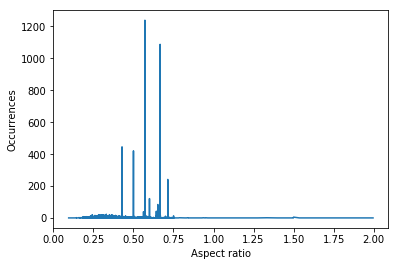

In [6]:

plt.figure()
plt.plot(unique,ret_counts)
plt.xlabel('Aspect ratio')
plt.ylabel('Occurrences')

# Train and Validation Split

In [7]:
def resize_images(folder1, folder2):
     #images = []
    for filename in os.listdir(folder1):
        img = cv2.imread(os.path.join(folder1,filename))
        chan = img.shape[-1]
        if chan==3:
            g_img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            new_img = cv2.resize(g_img,(224,224),interpolation=cv2.INTER_AREA)
        else:
             new_img = cv2.resize(img,(224,224),interpolation=cv2.INTER_AREA)
        if new_img is not None:
            out_path = os.path.join(folder2,filename)
            cv2.imwrite(out_path,new_img)

In [8]:
resize_images('data/train/','data/train_resized_gray/')

In [9]:
df_ohe = pandas.get_dummies(df['Id'])

In [10]:
df_comb = pandas.concat([df['Image'],df_ohe], axis=1)

In [11]:
df_comb.head()

,Image,new_whale,w_0013924,w_001ebbc,w_002222a,w_002b682,w_002dc11,w_0087fdd,w_008c602,w_009dc00,...,w_ff70408,w_ff7630a,w_ff94ad6,w_ffa7427,w_ffa78a5,w_ffb4e3d,w_ffbd74c,w_ffcd98e,w_ffda8b2,w_ffdab7a
1172,1e484732.jpg,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1230,200b53a2.jpg,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8688,e1eba938.jpg,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5080,842686a1.jpg,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5086,8441a59e.jpg,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
x = np.array(df['Image'])
x= 'data/train_resized_gray/' + x

Y = np.array(df_ohe)

In [13]:
msk = np.random.rand(len(x)) < 0.75
x_train = x[msk]
Y_train = Y[msk]

x_val = x[~msk]
Y_val = Y[~msk]

whale_names = list(df_comb.columns.values)
whale_names = whale_names[1:]

print('There are %d training images.' % len(x_train))
print('There are %d validation images.' % len(x_val))
print('There are %d whale categories.' % len(whale_names))

There are 7479 training images.
There are 2371 validation images.
There are 4251 whale categories.


# Initial Network

In [16]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [17]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True   

# pre-process the data for Keras
train_tensors = paths_to_tensor(x_train).astype('float32')/255
valid_tensors = paths_to_tensor(x_val).astype('float32')/255


100%|██████████| 2371/2371 [00:04<00:00, 488.14it/s]


In [29]:
#Dataset Augmentation

from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen = ImageDataGenerator(
    width_shift_range=0.2,  # randomly shift images horizontally (10% of total width)
    height_shift_range=0.2,  # randomly shift images vertically (10% of total height)
    horizontal_flip=True, # randomly flip images horizontally
    rotation_range=20,
    vertical_flip=True) #range for random rotations

# fit augmented image generator on data
datagen.fit(train_tensors)
datagen.fit(valid_tensors)

In [30]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### TODO: Define your architecture.

model.add(Conv2D(filters = 64, kernel_size = 5, padding = 'valid', activation = 'relu', kernel_initializer='random_normal', input_shape = (224, 224, 3))) 
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 32, kernel_size = 3, padding = 'valid', activation = 'relu', kernel_initializer='random_normal')) 
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))

model.add(Conv2D(filters = 16, kernel_size = 2, padding = 'valid', activation = 'relu', kernel_initializer='random_normal')) 
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.3))

model.add(Dense(4251, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 220, 220, 64)      4864      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 110, 110, 64)      0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 110, 110, 64)      0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 108, 108, 32)      18464     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 53, 53, 16)        2064      
__________

In [34]:
CUDA_VISIBLE_DEVICES=5,6,7

In [35]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [36]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 10

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, Y_train, 
          validation_data=(valid_tensors, Y_val),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 7479 samples, validate on 2371 samples
Epoch 1/10
7479/7479 [==============================] - 408s 55ms/step - loss: 8.1414 - acc: 0.0797 - val_loss: 8.1761 - val_acc: 0.0844

Epoch 00001: val_loss improved from inf to 8.17612, saving model to best.from_scratch.hdf5
Epoch 2/10
7479/7479 [==============================] - 406s 54ms/step - loss: 7.8091 - acc: 0.0816 - val_loss: 8.2310 - val_acc: 0.0844

Epoch 00002: val_loss did not improve from 8.17612
Epoch 3/10
7479/7479 [==============================] - 405s 54ms/step - loss: 7.7135 - acc: 0.0816 - val_loss: 8.3505 - val_acc: 0.0844

Epoch 00003: val_loss did not improve from 8.17612
Epoch 4/10
7479/7479 [==============================] - 404s 54ms/step - loss: 7.6796 - acc: 0.0816 - val_loss: 8.4477 - val_acc: 0.0844

Epoch 00004: val_loss did not improve from 8.17612
Epoch 5/10
7479/7479 [==============================] - 403s 54ms/step - loss: 7.6708 - acc: 0.0816 - val_loss: 8.5177 - val_acc: 0.0844

Epoch 00005: val_l

#### Using ResNet for Prediction

In [41]:
from tensorflow.python.keras.applications import ResNet50, MobileNet
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense

model2 = Sequential()

model2.add(MobileNet(include_top = False, pooling = 'avg', weights = 'imagenet'))

model2.add(Dense(4251, activation = 'softmax'))

model2.layers[0].trainable = False

model2.summary()

/home/Spartacus/anaconda3/lib/python3.6/site-packages/keras_applications/mobilenet.py:207: UserWarning: MobileNet shape is undefined. Weights for input shape (224, 224) will be loaded.
  warnings.warn('MobileNet shape is undefined.'


Exception: URL fetch failure on https://github.com/fchollet/deep-learning-models/releases/download/v0.6/mobilenet_1_0_224_tf_no_top.h5: None -- [Errno -2] Name or service not known

In [25]:
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [26]:
epochs = 10

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='best.ResNet50.hdf5', 
                               verbose=1, save_best_only=True)

model2.fit(train_tensors, Y_train, 
          validation_data=(valid_tensors, Y_val),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 7479 samples, validate on 2371 samples
Epoch 1/30
7479/7479 [==============================] - 405s 54ms/step - loss: 8.1875 - acc: 0.0773 - val_loss: 8.1415 - val_acc: 0.0844

Epoch 00001: val_loss improved from inf to 8.14152, saving model to best.Model2.hdf5
Epoch 2/30
7479/7479 [==============================] - 404s 54ms/step - loss: 7.8215 - acc: 0.0816 - val_loss: 8.2443 - val_acc: 0.0844

Epoch 00002: val_loss did not improve from 8.14152
Epoch 3/30
7479/7479 [==============================] - 403s 54ms/step - loss: 7.7286 - acc: 0.0816 - val_loss: 8.3498 - val_acc: 0.0844

Epoch 00003: val_loss did not improve from 8.14152
Epoch 4/30
7479/7479 [==============================] - 402s 54ms/step - loss: 7.6857 - acc: 0.0816 - val_loss: 8.4569 - val_acc: 0.0844

Epoch 00004: val_loss did not improve from 8.14152
Epoch 5/30
7479/7479 [==============================] - 402s 54ms/step - loss: 7.6341 - acc: 0.0816 - val_loss: 8.5973 - val_acc: 0.0844

Epoch 00005: val_loss di

KeyboardInterrupt: 